In this notebook we implemented a content-based method of recommendation using TF-IDF vectors on the descriptions of Amazon items, and also a matrix factorization approach (Collaborative Filtering) using Stochastic Gradient Descent and Alternating Least Squares.

# Content-based approach

In [ ]:
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
%matplotlib inline

In [301]:
data = pd.read_csv("ratings_grocery.csv", sep=",", header=None)
data.columns = ["user", "item", "rating", "timestamp"]

In [302]:
#Take relevant items
df2 = data.groupby(["item"]).count()
sl2 = list(df2[df2["user"] > 400].index)
df = data[data['item'].isin(sl2)]

#Take relevant users
df3 = df.groupby(["user"]).count()
sl3 = list(df3[df3["item"] > 5].index)
df_final = df[df['user'].isin(sl3)]

In [2]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [304]:
meta = getDF("meta_grocery.gz")
meta = meta[["description", "asin"]]

In [305]:
import pandas as pd
import time
import redis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [306]:
meta100 = meta100[meta100["asin"].isin(df_final["item"].unique())].dropna()
df = df_final[df_final["item"].isin(meta100["asin"])]

In [ ]:
meta100.shape

In [237]:
tf = TfidfVectorizer(analyzer='word',
                             ngram_range=(1,3),
                             min_df=0,
                             stop_words='english')

tfidf_matrix = tf.fit_transform(meta100['description'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [188]:
def find_similar(tfidf_matrix, index, top_n = 3):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_products_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_products_indices][0:top_n]

In [238]:
#We find the top-k similar products to product number 100
find_similar(tfidf_matrix, 100,4)

[(8, 0.06266168583221296),
 (85, 0.056279511378638604),
 (56, 0.054523909199267064),
 (15, 0.052582647241400104)]

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def mse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_squared_error(prediction, ground_truth)

In [239]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(df, test_size=0.2)

In [240]:
n_users = len(df["user"].unique())
n_items = len(df["item"].unique())
train_ratings_matrix = np.zeros((n_users, n_items))
test_ratings_matrix = np.zeros((n_users, n_items))

list_users = list(df["user"].unique())
list_items = list(df["item"].unique())

print(n_users)
print(n_items)

663
174


In [244]:
for row in train_data.itertuples():
    train_ratings_matrix[list_users.index(row[1]), list_items.index(row[2])] = row[3]

for row in test_data.itertuples():
    test_ratings_matrix[list_users.index(row[1]), list_items.index(row[2])] = row[3]

In [245]:
def predict_item_based(train_ratings_matrix,N):
    deb = 0
    X_pred = np.zeros((test_ratings_matrix.shape[0],test_ratings_matrix.shape[1]))
    for u in range(n_users):
        for i in range(n_items):
    #for u, i in zip(range(n_users),range(n_items)):
            a=0.
            list_similar = find_similar(tfidf_matrix, i,N)
            for n in range(len(list_similar)):
                if train_ratings_matrix[u,list_similar[n][0]] != 0. :
                                        X_pred[u,i] += list_similar[n][1] * train_ratings_matrix[u,list_similar[n][0]]
                                        a += list_similar[n][1]
                                         
        if X_pred[u,i] != 0:
            X_pred[u,i]= X_pred[u,i]/a
    return X_pred

In [246]:
test = predict_item_based(train_ratings_matrix, 500)

In [279]:
mse(test[test_ratings_matrix.nonzero()].flatten(), test_ratings_matrix[test_ratings_matrix.nonzero()].flatten())

2.463518755773002

# Collaborative Filtering

# Exploration

In [284]:
data = pd.read_csv("ratings_Musical_Instruments.csv", sep=",", header=None)
data.columns = ["user","item","rating","timestamp"]
print("Number of samples is", data.shape[0])
data.head(5)

Number of samples is 500176


,user,item,rating,timestamp
0,A1YS9MDZP93857,0006428320,3.0,1394496000
1,A3TS466QBAWB9D,0014072149,5.0,1370476800
2,A3BUDYITWUSIS7,0041291905,5.0,1381708800
3,A19K10Z0D2NTZK,0041913574,5.0,1285200000
4,A14X336IB4JD89,0201891859,1.0,1350432000


In [285]:
data_item = data.groupby(["item"]).mean()["rating"]

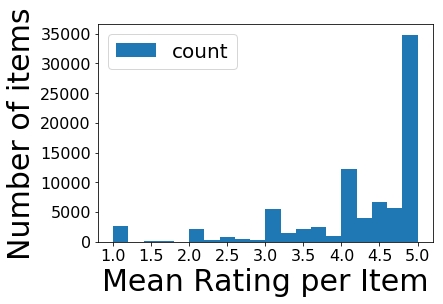

In [300]:
plt.hist(data_item, bins=20, label="count")
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('Mean Rating per Item', fontsize=30);
plt.ylabel('Number of items', fontsize=30);

In [287]:
data_user = data.groupby(["user"]).mean()["rating"]

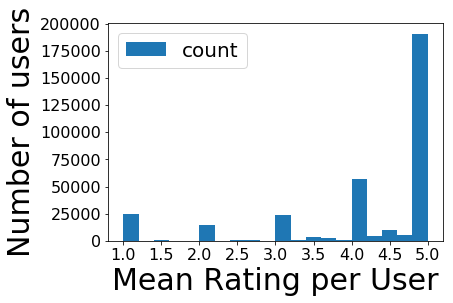

In [297]:
plt.hist(data_user, bins=20, label="count")
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Mean Rating per User', fontsize=30)
plt.ylabel('Number of users', fontsize=30)

In [289]:
data_nb_rate = data.groupby(["user"]).count()["rating"]

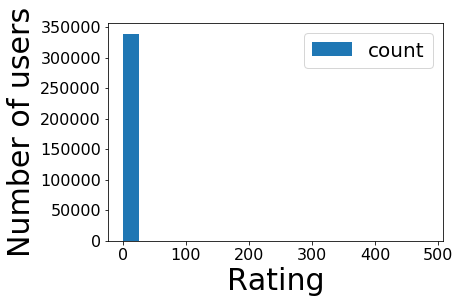

In [295]:
plt.hist(data_nb_rate, bins=20, label="count")
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Rating', fontsize=30)
plt.ylabel('Number of users', fontsize=30)

In [291]:
data_nb_rate = pd.Series(data_nb_rate)
my_count = data_nb_rate.value_counts()

In [292]:
for k in range(1,11,1):
    print(my_count[k],"people ranked",k,"items.")

270914 people ranked 1 items.
39277 people ranked 2 items.
13015 people ranked 3 items.
5968 people ranked 4 items.
3226 people ranked 5 items.
1973 people ranked 6 items.
1230 people ranked 7 items.
786 people ranked 8 items.
569 people ranked 9 items.
430 people ranked 10 items.


In [299]:
print(len(data["user"].unique()))
print(len(data["item"].unique()))
print(len(data))

339231
83046
500176


# Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
from sklearn import cross_validation as cv
%matplotlib inline

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [256]:
data = pd.read_csv("ratings_Musical_Instruments.csv", sep=",", header=None)
data.columns = ["user", "item", "rating", "timestamp"]

#Take relevant items
df2 = data.groupby(["item"]).count()
sl2 = list(df2[df2["user"] > 20].index)
df = data[data['item'].isin(sl2)]

#Take relevant users
df3 = df.groupby(["user"]).count()
sl3 = list(df3[df3["item"] > 5].index)
df_final = df[df['user'].isin(sl3)]

In [257]:
train_data, test_data = cv.train_test_split(df_final, test_size=0.1)

n_users = len(df_final["user"].unique())
n_items = len(df_final["item"].unique())
train_ratings_matrix = np.zeros((n_users, n_items))
test_ratings_matrix = np.zeros((n_users, n_items))
list_users = list(df_final["user"].unique())
list_items = list(df_final["item"].unique())

for row in train_data.itertuples():
    train_ratings_matrix[list_users.index(row[1]), list_items.index(row[2])] = row[3]

for row in test_data.itertuples():
    test_ratings_matrix[list_users.index(row[1]), list_items.index(row[2])] = row[3]

In [258]:
# Index matrix for training data
I = train_ratings_matrix.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
J = test_ratings_matrix.copy()
J[J > 0] = 1
J[J == 0] = 0

In [265]:
# Calculate the RMSE
def mse(I,R,Q,P):
    return np.sum((I * (R - np.dot(P.T,Q)))**2)/len(R[R > 0])

In [283]:
train_ratings_matrix.shape

(1762, 2966)

# SGD-WR

In [263]:
lmbda = 0.1 
k = 4 
gamma=0.01

In [277]:
%%time

n_iter = 15

train_errors_sgd = []
test_errors_sgd = []

a, b = train_ratings_matrix.shape
P = np.random.rand(k,a) 
Q = np.random.rand(k,b) 
users,items = train_ratings_matrix.nonzero()     

for n in range(n_iter):
    for u, i in zip(users,items):
        error = train_ratings_matrix[u, i] - np.dot(P[:,u].T,Q[:,i])
        P[:,u] += gamma * ( error * Q[:,i] - lmbda * P[:,u]) 
        Q[:,i] += gamma * ( error * P[:,u] - lmbda * Q[:,i])  
    train_mse = mse(I,train_ratings_matrix,Q,P) 
    test_mse = mse(J,test_ratings_matrix,Q,P) 
    train_errors_sgd.append(train_mse)
    test_errors_sgd.append(test_mse)

CPU times: user 19.8 s, sys: 1.94 s, total: 21.7 s
Wall time: 25.8 s


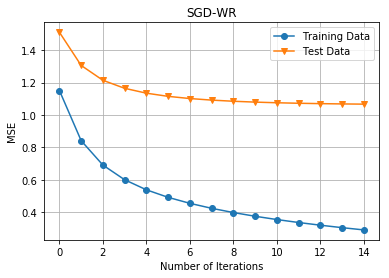

In [278]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_iter), train_errors_sgd, marker='o', label='Training Data');
plt.plot(range(n_iter), test_errors_sgd, marker='v', label='Test Data');
plt.title('SGD-WR')
plt.xlabel('Number of Iterations');
plt.ylabel('MSE');
plt.legend()
plt.grid()
plt.show()

In [281]:
print("MSE score after",n_iter,"iterations is:",np.round(test_errors_sgd[-1],2))

MSE score after 15 iterations is: 1.07


In [270]:
def SGD(k,lmbda,gamma):
    n_iter = 15

    train_errors_sgd = []
    test_errors_sgd = []

    a, b = train_ratings_matrix.shape
    P = np.random.rand(k,a) 
    Q = np.random.rand(k,b) 
    users,items = train_ratings_matrix.nonzero()     

    for n in range(n_iter):
        for u, i in zip(users,items):
            error = train_ratings_matrix[u, i] - np.dot(P[:,u].T,Q[:,i])
            P[:,u] += gamma * ( error * Q[:,i] - lmbda * P[:,u]) 
            Q[:,i] += gamma * ( error * P[:,u] - lmbda * Q[:,i])  
    return P,Q

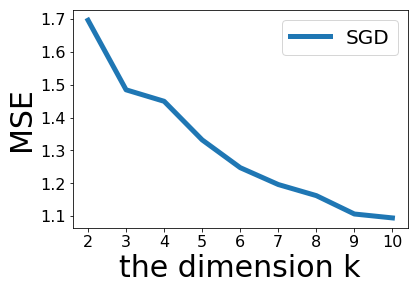

Best MSE of 1.09 obtained for k = 10


In [271]:
test_mse = []
best_mse = 0
lmbda = 0.1 
gamma=0.01

list_k = [2,3,4,5,6,7,8, 9, 10]

for k in list_k:
    P,Q = SGD(k,lmbda,gamma)
    test_mse += [mse(J,test_ratings_matrix,Q,P)]

best_mse = min(test_mse)
best_k = list_k[test_mse.index(min(test_mse))]
plt.plot(list_k, test_mse, label='SGD', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('the dimension k', fontsize=30)
plt.ylabel('MSE', fontsize=30)
plt.show()
print("Best MSE of",np.round(best_mse,2),"obtained for k =",best_k)

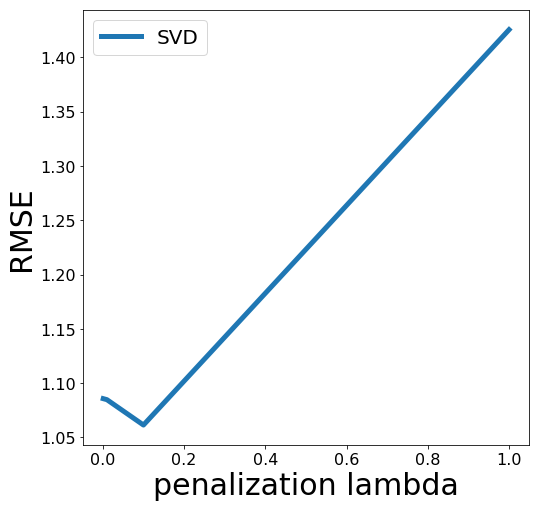

Best RMSE of 1.06 obtained for k = 0.1


In [125]:
test_mse = []
best_mse = 0
list_lmbda = [1,0.1,0.01,0.001]
k=best_k
gamma=gamma

for lmbda in list_lmbda:
    P,Q = SGD(k,lmbda,gamma)
    test_mse += [mse(J,test_ratings_matrix,Q,P)]

best_mse = min(test_mse)
best_lmbda = list_lmbda[test_mse.index(min(test_mse))]
plt.figure(figsize=(8, 8))
plt.plot(list_lmbda, test_mse, label='SVD', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('penalization lambda', fontsize=30)
plt.ylabel('MSE', fontsize=30)
plt.show()
print("Best MSE of",np.round(best_mse,2),"obtained for lmbda =",best_lmbda)

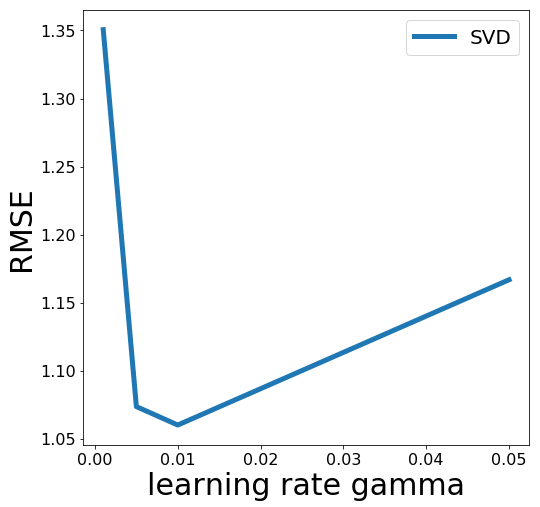

Best RMSE of 1.06 obtained for k = 0.01


In [130]:
test_mse = []
best_mse = 0
list_gamma = [0.001,0.005, 0.01, 0.05]
k = best_k
lmbda = best_lmbda

for gamma in list_gamma:
    P,Q = SGD(k,lmbda,gamma)
    test_mse += [mse(J,test_ratings_matrix,Q,P)]

best_mse = min(test_mse)
best_gamma = list_gamma[test_mse.index(min(test_mse))]
plt.figure(figsize=(8, 8))
plt.plot(list_gamma, test_mse, label='SVD', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('learning rate gamma', fontsize=30)
plt.ylabel('MSE', fontsize=30)
plt.show()
print("Best MSE of",np.round(best_mse,2),"obtained for gamma =",best_gamma)

# ALS

In [272]:
lmbda = 0.1 
k = 20

In [276]:
%%time

n_iter = 15

train_errors_als = []
test_errors_als = []

a, b = train_ratings_matrix.shape
P = np.random.rand(k,a) 
Q = np.random.rand(k,b) 
Q[0,:] = train_ratings_matrix[train_ratings_matrix != 0].mean(axis=0) # Average to take into account the bias of items
E = np.eye(k)

for n in range(n_iter):
    # Fix Q and estimate P
    for i, Ii in enumerate(I):
        nui = np.count_nonzero(Ii) # Number of items user i has rated
        if (nui == 0): 
            nui = 1 # Avoid having a singular matrix
    
        Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
        Vi = np.dot(Q, np.dot(np.diag(Ii), train_ratings_matrix[i].T))
        P[:,i] = np.linalg.solve(Ai,Vi)
        
    # Fix P and estimate Q
    for j, Ij in enumerate(I.T):
        nmj = np.count_nonzero(Ij) # Number of users that rated item j
        if (nmj == 0): 
            nmj = 1 # Avoid having a singular matrix
        
        Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
        Vj = np.dot(P, np.dot(np.diag(Ij), train_ratings_matrix[:,j]))
        Q[:,j] = np.linalg.solve(Aj,Vj)
    
    train_mse = mse(I,train_ratings_matrix,Q,P)
    test_mse = mse(J,test_ratings_matrix,Q,P)
    train_errors_als.append(train_mse)
    test_errors_als.append(test_mse)

'%%time\n\nn_iter = 15\n\ntrain_errors_als = []\ntest_errors_als = []\n\na, b = train_ratings_matrix.shape\nP = np.random.rand(k,a) \nQ = np.random.rand(k,b) \nQ[0,:] = train_ratings_matrix[train_ratings_matrix != 0].mean(axis=0) # Average to take into account the bias of items\nE = np.eye(k)\n\nfor n in range(n_iter):\n    # Fix Q and estimate P\n    for i, Ii in enumerate(I):\n        nui = np.count_nonzero(Ii) # Number of items user i has rated\n        if (nui == 0): \n            nui = 1 # Avoid having a singular matrix\n    \n        Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E\n        Vi = np.dot(Q, np.dot(np.diag(Ii), train_ratings_matrix[i].T))\n        P[:,i] = np.linalg.solve(Ai,Vi)\n        \n    # Fix P and estimate Q\n    for j, Ij in enumerate(I.T):\n        nmj = np.count_nonzero(Ij) # Number of users that rated item j\n        if (nmj == 0): \n            nmj = 1 # Avoid having a singular matrix\n        \n        Aj = np.dot(P, np.dot(np.diag(Ij), P.T))

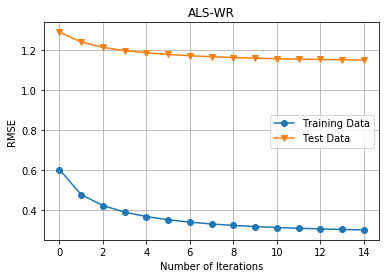

In [93]:
# Check performance by plotting train and test errors

plt.plot(range(n_iter), train_errors_als, marker='o', label='Training Data');
plt.plot(range(n_iter), test_errors_als, marker='v', label='Test Data');
plt.title('ALS-WR')
plt.xlabel('Number of Iterations');
plt.ylabel('MSE');
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("MSE score after",n_iter,"iterations is:"np.round(test_errors_als[-1],2))

# Comparison between SGD and ALS

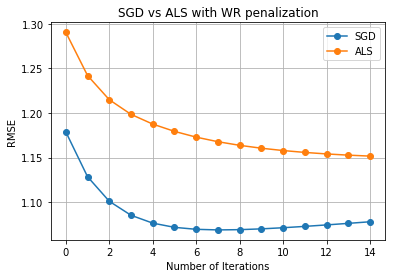

In [94]:
plt.plot(range(n_iter), test_errors_sgd, marker='o', label='SGD');
plt.plot(range(n_iter), test_errors_als, marker='o', label='ALS');
plt.title('SGD vs ALS with WR penalization')
plt.xlabel('Number of Iterations');
plt.ylabel('MSE');
plt.legend()
plt.grid()
plt.show()